In [1]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir

In [2]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [3]:
path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\1423\\AnalysisFiles\\'

def list_files1(directory):
    return [f for f in listdir(directory) if '1423' in f]

sampledf = pd.DataFrame(columns=['filename','Cell_line','Editor','Replicate'])
filelist = list_files1(path)
sampledf['filename'] = filelist
sampledf['Library'] = sampledf['filename'].apply(lambda x: x.split('_')[1])
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x.split('_')[2])
sampledf['Day'] = sampledf['filename'].apply(lambda x: x.split('_')[-1][1:-4] if not 'ctrl' in x else '')
sampledf['Editor_Day'] = sampledf.apply(lambda x: x.Editor+'_'+x.Day ,axis=1)
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x.split('_')[-2] if not 'ctrl' in x else x.split('_')[-1][:1])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'ctrl' in x else False)
sampledf['repname'] = sampledf.apply(lambda x: x.Editor+"_"+x.Day+"_"+x.Replicate,axis=1)
#sampledf['Cell_line_Editor'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor,axis=1)
#sampledf['repname'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor+"_"+x.Replicate,axis=1)

In [4]:
templatedf = pd.read_csv('C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\1423\\Demultiplexed\\SaCas9_o1423.csv')

### Calculate control characteristics for each experimental setup

In [5]:
ctrllist = sampledf[sampledf['Editor'] == 'ctrl']
ctrldf = templatedf.copy()
for index, row in ctrllist.iterrows():
    controlrepdf = pd.read_csv(path+row.filename)
    ctrldf[row.repname+'_totalreads'] = controlrepdf['totalreads']
    controlrepdf['percentageindel'] = controlrepdf.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
    controlrepdf['percentageunedited'] = controlrepdf.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
    ctrldf[row.repname+'_percentageunedited'] = controlrepdf['percentageunedited']
    ctrldf[row.repname+'_percentageindel'] = controlrepdf['percentageindel']
    ctrldf[row.repname+'_uneditedcount'] = controlrepdf['uneditedcount']
    ctrldf[row.repname+'_indelcount'] = controlrepdf['indelcount']

for index, row in ctrllist.iterrows():    
    ctrldf = ctrldf[ctrldf[row.repname+'_totalreads'] > 100]
    ctrldf = ctrldf[ctrldf[row.repname+'_percentageindel'] < 30]

In [6]:
editordaylist = sampledf['Editor_Day'].unique()
editordaylist = [x for x in editordaylist if not 'ctrl' in x]
experimentdict = {}
for editor_day in editordaylist:
    experimentdf = templatedf.copy()
    for index, row in sampledf[sampledf['Editor_Day'] == editor_day].iterrows():
        dataframe = pd.read_csv(path+row.filename)
        dataframename = row.Editor+"_"+row.Day+"_"+row.Replicate
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        dataframe['percentageindel'] = dataframe.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
        dataframe['percentageunedited'] = dataframe.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
    replicates = list(sampledf[sampledf['Editor_Day'] == editor_day].repname)
    controldf = sampledf[(sampledf['Editor'] == 'ctr')]
    #controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    ctrluneditedlist = []
    ctrlindellist = []
    lib = "1423"
    for index, row in ctrllist.iterrows():
        ctrluneditedlist.append(row.repname+'_percentageunedited')
        ctrlindellist.append(row.repname+'_percentageindel')
        
    experimentdf[lib+'_ctr'+'_percentageunedited'] = ctrldf[ctrluneditedlist].mean(axis=1)
    experimentdf[lib+'_ctr'+'_percentageindel'] = ctrldf[ctrlindellist].mean(axis=1)
    #print()
    #print(controlname)
    #print(cellline)
    cutoff = 100
    initialtemplen = len(experimentdf)
    #print('Total variants:',initialtemplen)
    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[replicate+'_totalreads']>cutoff]

    experimentdict[editor_day] = experimentdf

### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [7]:
sampledf_woctr = sampledf[sampledf['Editor'] != 'ctrl']

In [8]:
editordaydf = sampledf_woctr.copy()
editordaydf = editordaydf[editordaydf['Replicate'] == "1"]
editordaydf = editordaydf.set_index('Editor_Day')

cols = ['Editor', 'Library', 'Day']
editordaydf = editordaydf[cols]
editordaydf

,Editor,Library,Day
Editor_Day,,,
p619_10,p619,1423,10
p619_3,p619,1423,3
p619_5,p619,1423,5
p619_7,p619,1423,7
p620_10,p620,1423,10
p620_3,p620,1423,3
p620_5,p620,1423,5
p620_7,p620,1423,7
p621_10,p621,1423,10


In [9]:
for editor_day in experimentdict:
    print(editor_day)
    replicatelist = list(sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day]['repname'])
    ctrname = lib+'_ctr'
    
    for replicate in replicatelist:
        print(replicate)
        repnr = replicate.split('_')[-1]
        experimentdict[editor_day][replicate+'_percentageindel_corrected_individual'] = experimentdict[editor_day].apply(lambda x: ((x[replicate+'_percentageindel']-x[ctrname+'_percentageindel'])/((100-x[ctrname+'_percentageindel'])/100)),axis=1)
        editordaydf.at[editor_day,repnr +'_meanindel'] = None
        editordaydf.at[editor_day,repnr +'_meanindel'] = experimentdict[editor_day][[replicate +'_percentageindel_corrected_individual']].mean()
        
    allreps = []
    for index,row in sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day].iterrows():
        rep = row.Editor_Day+'_'+row.Replicate
        allreps.append(rep)
        
    print(allreps)    
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][[x +'_percentageindel_corrected_individual' for x in allreps]].mean(axis=1)
    
       
    # Clip editing rates to be between 0 and 100
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][editor_day+'_averageindel'].clip(0,100)
    
    experimentdict[editor_day] = experimentdict[editor_day].dropna(subset=[editor_day+'_averageindel'])
    
    replist = ['1_meanindel','2_meanindel','3_meanindel']
    
    editordaydf.at[editor_day,'numberofvariants'] = len(experimentdict[editor_day])
    editordaydf.at[editor_day,'meanindel'] = experimentdict[editor_day][editor_day+'_averageindel'].mean()
    editordaydf.at[editor_day,'standarddeviation'] = experimentdict[editor_day][editor_day+'_averageindel'].std()
    experimentdict[editor_day].to_csv('.//1423//AnalysisFiles//summary//20220912_'+editor_day+'_analysis_dataframe.csv')

p619_10
p619_10_1
p619_10_2
p619_10_3
['p619_10_1', 'p619_10_2', 'p619_10_3']
p619_3
p619_3_1
p619_3_2
p619_3_3
['p619_3_1', 'p619_3_2', 'p619_3_3']
p619_5
p619_5_1
p619_5_2
p619_5_3
['p619_5_1', 'p619_5_2', 'p619_5_3']
p619_7
p619_7_1
p619_7_2
p619_7_3
['p619_7_1', 'p619_7_2', 'p619_7_3']
p620_10
p620_10_1
p620_10_2
p620_10_3
['p620_10_1', 'p620_10_2', 'p620_10_3']
p620_3
p620_3_1
p620_3_2
p620_3_3
['p620_3_1', 'p620_3_2', 'p620_3_3']
p620_5
p620_5_1
p620_5_2
p620_5_3
['p620_5_1', 'p620_5_2', 'p620_5_3']
p620_7
p620_7_1
p620_7_2
p620_7_3
['p620_7_1', 'p620_7_2', 'p620_7_3']
p621_10
p621_10_1
p621_10_2
p621_10_3
['p621_10_1', 'p621_10_2', 'p621_10_3']
p621_3
p621_3_1
p621_3_2
p621_3_3
['p621_3_1', 'p621_3_2', 'p621_3_3']
p621_5
p621_5_1
p621_5_2
p621_5_3
['p621_5_1', 'p621_5_2', 'p621_5_3']
p621_7
p621_7_1
p621_7_2
p621_7_3
['p621_7_1', 'p621_7_2', 'p621_7_3']
p622_10
p622_10_1
p622_10_2
p622_10_3
['p622_10_1', 'p622_10_2', 'p622_10_3']
p622_3
p622_3_1
p622_3_2
p622_3_3
['p622_3_1', 'p

In [10]:
for index, row in editordaydf.iterrows():
    editordaydf.at[index,'replicate_meanindel'] = (row['1_meanindel'] + row['2_meanindel'] + row['3_meanindel']) / 3
    editordaydf.at[index,'replicate_std'] = np.std([row['1_meanindel'],row['2_meanindel'],row['3_meanindel']])

In [11]:
editordaydf['Day'] = editordaydf['Day'].apply(lambda x: int(x))
editordaydf = editordaydf.sort_values('Day')
editordaydf = editordaydf.sort_values('Editor')
editordaydf['filename'] = editordaydf.apply(lambda x: '20220912_'+x.Editor+'_'+str(x.Day)+'_analysis_dataframe.csv',axis=1)
editordaydf.to_csv('.//1423//AnalysisFiles//summary//20220912_1423_summary_mean_std.csv')
editordaydf

,Editor,Library,Day,1_meanindel,2_meanindel,3_meanindel,numberofvariants,meanindel,standarddeviation,replicate_meanindel,replicate_std,filename
Editor_Day,,,,,,,,,,,,
p619_3,p619,1423,3,60.852250,59.044937,60.579685,70.0,60.158957,17.553238,60.158957,0.795552,20220912_p619_3_analysis_dataframe.csv
p619_5,p619,1423,5,80.420274,80.378370,80.268206,70.0,80.355617,13.431524,80.355617,0.064133,20220912_p619_5_analysis_dataframe.csv
p619_7,p619,1423,7,84.807526,83.887461,85.078517,70.0,84.591168,11.105259,84.591168,0.509746,20220912_p619_7_analysis_dataframe.csv
p619_10,p619,1423,10,86.877833,87.070637,87.686545,70.0,87.211672,9.203555,87.211672,0.344888,20220912_p619_10_analysis_dataframe.csv
p620_3,p620,1423,3,54.012507,53.315876,51.677504,70.0,53.001962,23.904941,53.001962,0.978763,20220912_p620_3_analysis_dataframe.csv
p620_5,p620,1423,5,73.573369,72.740272,72.546112,70.0,72.953251,21.449969,72.953251,0.445596,20220912_p620_5_analysis_dataframe.csv
p620_7,p620,1423,7,77.079122,76.483020,77.906120,70.0,77.156087,20.044549,77.156087,0.583521,20220912_p620_7_analysis_dataframe.csv
p620_10,p620,1423,10,81.357900,81.624613,82.270465,70.0,81.750993,18.137060,81.750993,0.383121,20220912_p620_10_analysis_dataframe.csv
p621_3,p621,1423,3,8.198581,9.536530,8.228048,70.0,8.879103,12.330643,8.654386,0.623886,20220912_p621_3_analysis_dataframe.csv


In [12]:
editordaydf.index

Index(['p619_3', 'p619_5', 'p619_7', 'p619_10', 'p620_3', 'p620_5', 'p620_7',
       'p620_10', 'p621_3', 'p621_5', 'p621_7', 'p621_10', 'p622_3', 'p622_5',
       'p622_7', 'p622_10'],
      dtype='object', name='Editor_Day')

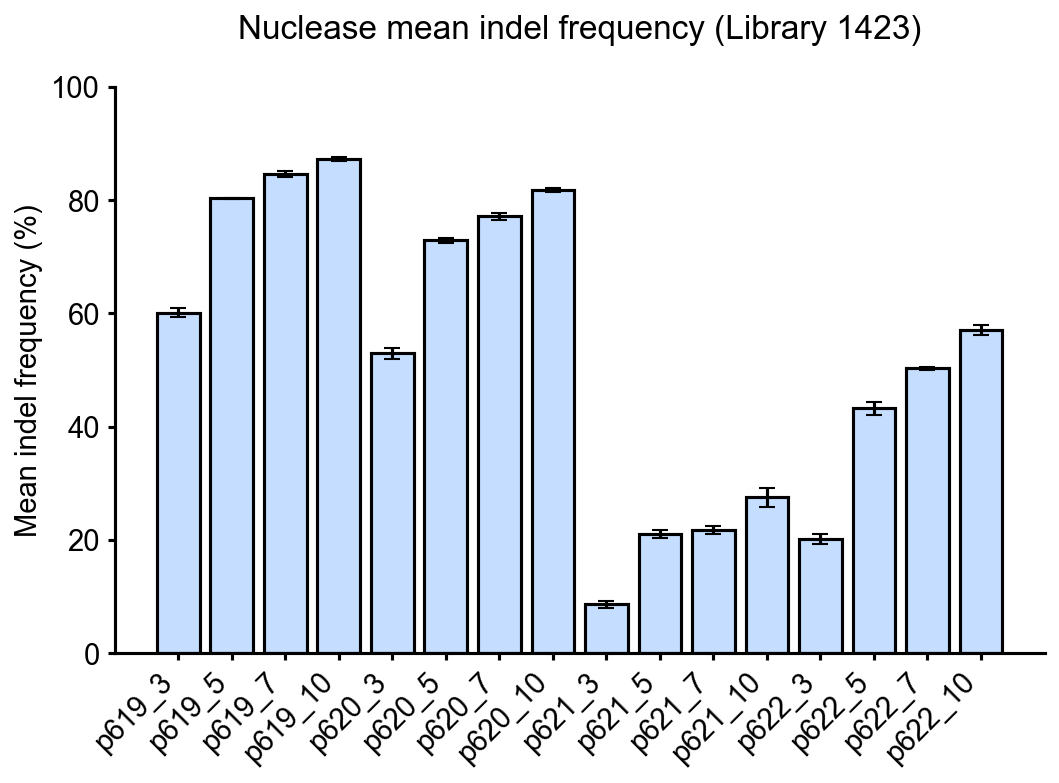

In [13]:
conditionlist = list(editordaydf.index)
meanlist = list(editordaydf.replicate_meanindel)
stdlist = list(editordaydf.replicate_std)

fig1, ax1 = plt.subplots(figsize = (8,5),dpi=150,sharex=True)
ax1.set_title('Nuclease mean indel frequency (Library 1423)\n', fontsize=titlesize)
ax1.bar(conditionlist,meanlist,yerr=stdlist, **bar_kwargs)
ax1.set_xticks(range(len(conditionlist)))
ax1.set_xticklabels(conditionlist, ha="right")
#ax1.set_yticks(np.linspace(0,1,11))
ax1.set_ylabel('Mean indel frequency (%)', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0, 100)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\04_Lukas_Schmidheini\\Nuclease\\1423\\'
#plt.savefig(figurepath+'Nuclease_1423_meanefficiency.pdf', format='pdf',
#        transparent=True,bbox_inches='tight')